# Building the supplement of $L$ in $M$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import scipy as sp
import itertools
import copy

!pip install nbimporter
import nbimporter
from ExtendingAlpha import getAlphaComplex, draw_2d_simplicial_complex
from BarySub import AbstractSubdivision

Defaulting to user installation because normal site-packages is not writeable


In [4]:
def subdivision( M, points ):
    
    try:
        Subs
    except NameError:
        Subs = {}

        for i in range(2,4+1):
            Subs[i] = AbstractSubdivision(i)
    
    n_points = points.shape[0]
    
    # vertices
    
    N_Verts = n_points + len(M)
    SubPoints = np.zeros((N_Verts, 2))
    
    SubPoints[ 0 : n_points , : ] = points
    
    for i in range(len(M)):
        
        bary = np.mean(points[M[i],:], axis=0)
        
        SubPoints[i+n_points,:] = bary
        
    subdivision = []
        
    # iterate over all simplices
    for s, sigma in enumerate(M):
        
        #print("We consider simplex ", sigma)
        l = len(sigma)
        #print("Simplex on ",l," points")
        
        for sub in Subs[l]:
            
            #print("This sub is ",sub)
            newSimplex = []
            for face in sub:
                
                thisFace = [ sigma[h] for h in face ]
                #print("This face is ",thisFace)
                
                if len(thisFace)>1:
                    thisIndex = M.index(thisFace)
                    
                    #print("That is index ", thisIndex)
                
                    newSimplex.append(thisIndex + n_points)
                    
                else:
                    thisIndex = thisFace[0]
                    newSimplex.append(thisIndex)
                
            
            #print("So we add simplex ", newSimplex)    
                
            subdivision.append( newSimplex )
            
    
    return subdivision, SubPoints

In [5]:
def draw_Sup(simplices, subSimplices, supSimplices, subComplexIndices,  pos, posSub, boundaryComponent=None, excludedVerts=None, return_pos=False, fig = None):
    """
    Draw a simplicial complex up to dimension 2 from a list of simplices, as in [1].
        
        Args
        ----
        simplices: list of lists of integerss
            List of simplices to draw. Sub-simplices are not needed (only maximal).
            For example, the 2-simplex [1,2,3] will automatically generate the three
            1-simplices [1,2],[2,3],[1,3] and the three 0-simplices [1],[2],[3].
            When a higher order simplex is entered only its sub-simplices
            up to D=2 will be drawn.
        
        pos: dict (default=None)
            If passed, this dictionary of positions d:(x,y) is used for placing the 0-simplices.
            The standard nx spring layour is used otherwise.
           
        ax: matplotlib.pyplot.axes (default=None)
        
        return_pos: dict (default=False)
            If True returns the dictionary of positions for the 0-simplices.
            
        References
        ----------    
        .. [1] I. Iacopini, G. Petri, A. Barrat & V. Latora (2018)
               "Simplicial Models of Social Contagion".
               arXiv preprint arXiv:1810.07031..
    """

    
    #List of 0-simplices
    nodes =list(set(itertools.chain(*simplices)))
    
    #List of 1-simplices
    edges = list(set(itertools.chain(*[[tuple(sorted((i, j))) for i, j in itertools.combinations(simplex, 2)] for simplex in simplices])))

    #List of 2-simplices
    triangles = list(set(itertools.chain(*[[tuple(sorted((i, j, k))) for i, j, k in itertools.combinations(simplex, 3)] for simplex in simplices])))
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_xlim([0, 270])      
    ax.set_ylim([0, 270])
    ax.set_xlim([-.1, 1.1])      
    ax.set_ylim([-.1, 1.1])
    ax.get_xaxis().set_ticks([])  
    ax.get_yaxis().set_ticks([])
    ax.axis('on')
       
    if pos is None:
        # Creating a networkx Graph from the edgelist
        G = nx.Graph()
        G.add_edges_from(edges)
        # Creating a dictionary for the position of the nodes
        pos = nx.spring_layout(G)
        
    # Drawing the edges
    for i, j in edges:
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        line = plt.Line2D([ x0, x1 ], [y0, y1 ],color = 'blue', zorder = 1, lw=1.5)
        ax.add_line(line);
    
    # Filling in the triangles
    for i, j, k in triangles:
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        (x2, y2) = pos[k]
        tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                          edgecolor = 'white', facecolor = plt.cm.Blues(0.6),
                          zorder = 2, alpha=0.4, lw=0.5)
        ax.add_patch(tri);
        
    # Drawing the nodes 
    #for i in nodes:
    for i in range(len(pos)):
        (x, y) = pos[i]
        #  radius was 0.1
        circ = plt.Circle([ x, y ], radius = 0.01, zorder = 4, lw=0.5,
                          edgecolor = 'Black', facecolor = 'Blue')
        ax.add_patch(circ);
     
    # For the subcomplex
        
    #List of 0-simplices
    nodes =list(set(itertools.chain(*subSimplices)))
    
    #List of 1-simplices
    edges = list(set(itertools.chain(*[[tuple(sorted((i, j))) for i, j in itertools.combinations(simplex, 2)] for simplex in subSimplices])))

    #List of 2-simplices
    triangles = list(set(itertools.chain(*[[tuple(sorted((i, j, k))) for i, j, k in itertools.combinations(simplex, 3)] for simplex in subSimplices])))
    
    
    # Drawing the edges
    for i, j in edges:
        (x0, y0) = posSub[i]
        (x1, y1) = posSub[j]
        line = plt.Line2D([ x0, x1 ], [y0, y1 ],color = 'green', zorder = 2, lw=1.5)
        ax.add_line(line);
    
    # Filling in the triangles
    for i, j, k in triangles:
        (x0, y0) = posSub[i]
        (x1, y1) = posSub[j]
        (x2, y2) = posSub[k]
        tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                          edgecolor = plt.cm.Greens(0.3), facecolor = plt.cm.Greens(0.6),
                          zorder = 2, alpha=0.4, lw=0.5)
        ax.add_patch(tri);
        
    # Drawing the nodes 
    #for i in nodes:
    for i in range(len(posSub)):
        (x, y) = posSub[i]
        #  radius was 0.1
        circ = plt.Circle([ x, y ], radius = 0.01, zorder = 4, lw=0.5,
                          edgecolor = 'Black', facecolor = 'Green')
        ax.add_patch(circ);
        
        
    #List of 0-simplices
    nodes =list(set(itertools.chain(*supSimplices)))
    
    #List of 1-simplices
    edges = list(set(itertools.chain(*[[tuple(sorted((i, j))) for i, j in itertools.combinations(simplex, 2)] for simplex in supSimplices])))

    #List of 2-simplices
    triangles = list(set(itertools.chain(*[[tuple(sorted((i, j, k))) for i, j, k in itertools.combinations(simplex, 3)] for simplex in supSimplices])))
    
    
    # Drawing the edges
    for i, j in edges:
        
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        
        if excludedVerts is not None and i in excludedVerts:

            Color = u'#ff7f0e'
        else:
            Color = 'red'

        
        line = plt.Line2D([ x0, x1 ], [y0, y1 ],color = Color, zorder = 2, lw=1.5)
        ax.add_line(line);
    
    # Filling in the triangles
    for i, j, k in triangles:
        
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        (x2, y2) = pos[k]
        
        if excludedVerts is not None and i in excludedVerts:

            Color = plt.cm.Oranges(0.6)
        else:
            Color = plt.cm.Reds(0.6)
                
       
        
        tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                          edgecolor = 'white', facecolor = Color,
                          zorder = 2, alpha=0.4, lw=0.5)
        ax.add_patch(tri);
        
    # Drawing the nodes 
    #for i in nodes:
    for i in range(len(pos)):
         if i not in subComplexIndices:
            (x, y) = pos[i]
            #  radius was 0.1
            
            
            if excludedVerts is not None and i in excludedVerts:

                Color = u'#ff7f0e'
            else:
                Color = 'Red'
            
            circ = plt.Circle([ x, y ], radius = 0.01, zorder = 4, lw=0.5,
                              edgecolor = 'Black', facecolor = Color)
            ax.add_patch(circ);
     
    # MARKED EDGES and Vertices
    
    if boundaryComponent is not None:
            for i,j in boundaryComponent:
                (x0 , y0) = pos[i]
                (x1 , y1) = pos[j]
                line = plt.Line2D([ x0, x1 ], [y0, y1 ],color = u'#ff7f0e', zorder = 2, lw=2)
                ax.add_line(line);
                
                circ = plt.Circle([ x0, y0 ], radius = 0.01, zorder = 4, lw=0.5, edgecolor = 'Black', facecolor = u'#ff7f0e')
                ax.add_patch(circ);
                
                circ = plt.Circle([ x1, y1 ], radius = 0.01, zorder = 4, lw=0.5, edgecolor = 'Black', facecolor = u'#ff7f0e')
                ax.add_patch(circ);
                
            
    
        
#     for i in nodes:
        
#         (x, y) = posLabels[i]
#         string = ' $x_{' + str(i) + '}$'
        
#         ax.text(x,y,string, color='black')
        

    #return fig


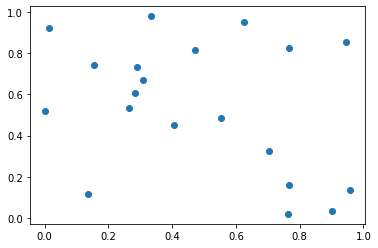

In [6]:
np.random.seed(12)
#np.random.seed(None)
pointsL = np.random.random_sample(size=(20,2))
plt.scatter(pointsL[:,0], pointsL[:,1])

In [7]:
L = getAlphaComplex(pointsL, .15)

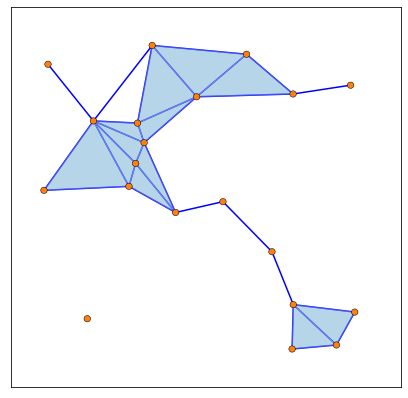

In [8]:
draw_2d_simplicial_complex(L, pointsL)

In [9]:
newPoints = np.random.random_sample(size=(5,2))

In [10]:
pointsM = np.vstack((pointsL, newPoints))
pointsM = pointsL.copy()
pointsM.shape

(20, 2)

In [11]:
M = getAlphaComplex(pointsM, 4)

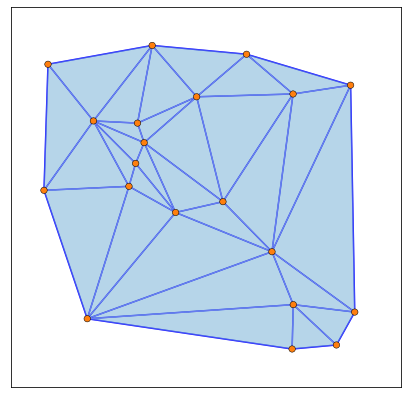

In [12]:
draw_2d_simplicial_complex(M, pointsM)

In [13]:
sM, sPointsM = subdivision(M, pointsM)

In [14]:
sL, sPointsL = subdivision(L,pointsL)

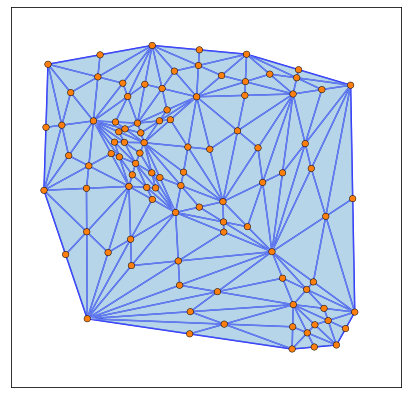

In [15]:
draw_2d_simplicial_complex(sM,sPointsM)

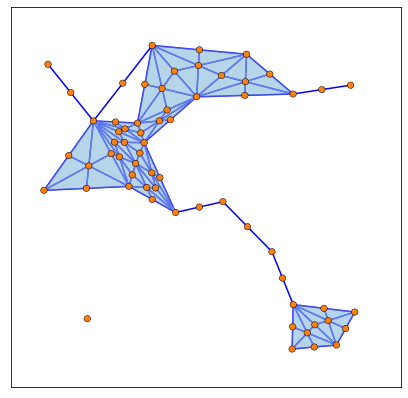

In [16]:
draw_2d_simplicial_complex(sL, sPointsL)

## Compute outer rim
In this example, we have more than one red connected component which does not correspond to a generator of the original subcomplex. 
This can happen because of non-convexity of the subcomplex: so when you extend it you add things to the supplement which were not cycles.
This can be solved by identifying which edges in the full extended complex are "outer": i.e. sum all top-dimensional simplices and compute the boundary. 
Then if any CC in red in the supplement contains vertices that correspond to an edge in the outer rim, they are to be discarded. <br>
This is essentially (must be proven though) the same as identifying the boundary of $M \cong D^d$ to a point at infinity, making it into $S^d$.

In [17]:
EL = [ x for x in sM if len(x)==2 ]
EL = list(sorted(EL))

Triangles = [ x for x in sM if len(x)==3 ]
Triangles = list(sorted(Triangles))

In [18]:
BoundaryOfTriangles = np.zeros( ( len(EL), len(Triangles) ), dtype=int)


for i,T in enumerate(Triangles):


    e0 = EL.index( [T[0], T[1]] )
    e1 = EL.index( [T[1], T[2]] )
    e2 = EL.index( [T[0], T[2]] )

    BoundaryOfTriangles[ e0 , i ] = 1
    BoundaryOfTriangles[ e1 , i ] = 1
    BoundaryOfTriangles[ e2 , i ] = 1

In [19]:
outerCycle = np.sum( BoundaryOfTriangles, axis = 1 )
outerCycle = np.mod(outerCycle, 2)

In [20]:
markedEdges = [ e for i,e in enumerate(EL) if outerCycle[i]==1 ]

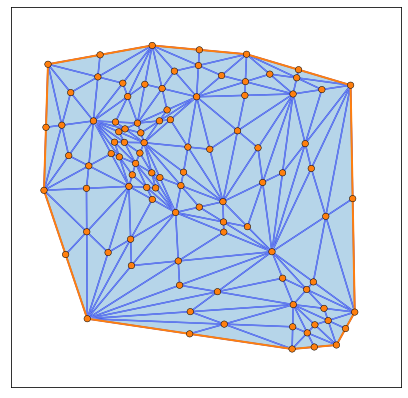

In [21]:
draw_2d_simplicial_complex(sM, sPointsM, markedEdges=markedEdges)

# The supplement of $L$ in $M$ is the simplicial subcomplex of $(M,L)'$ having no vertex that is a simplex of $L$. Alternatively, it is made of simplices of $M'$ that have no vertices in $L'$

In [22]:
def supplement( L , pointsL, M, pointsM ):
    ''' Assuming L < M is a subcomplex of M, compute the supplement of L in M
    
    '''
    
    sM, sPointsM = subdivision(M, pointsM)
    sL, sPointsL = subdivision(L, pointsL)
    
    # Find which vertices in sM are vertices of L
    
    SubComplexIndices = []
    for i in range(sPointsM.shape[0]):
        
        if any( all(sPointsM[i,:] == sPointsL[j,:]) for j in range(sPointsL.shape[0]) ):
            
            SubComplexIndices.append(i)
            
    supPoints = sPointsM.copy()
    
    # keep simplices if they are not in the smaller complex
    Lbar = [ m for m in sM if all([s not in SubComplexIndices for s in m ])  ]
    
    # Add vertices to Lbar!
    verticesLbar = [ [n] for n in range(sPointsM.shape[0]) if n not in SubComplexIndices ] 
    
    Lbar = verticesLbar + Lbar
            
    
    return Lbar, sL, sM, sPointsL, sPointsM, SubComplexIndices

In [23]:
Lbar, sL, sM, sPointsL, sPointsM, indices = supplement(L, pointsL, M, pointsM)

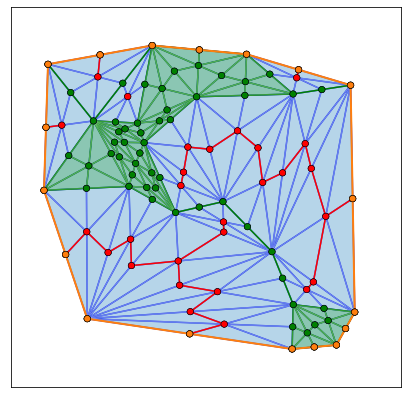

In [24]:
draw_Sup( sM , sL , Lbar, indices, pos = sPointsM, posSub = sPointsL, boundaryComponent = markedEdges )

## Connected components of $\bar{L}$
And which contain a vertex from the boundary of $M$

In [25]:
LbarCopy = copy.deepcopy(Lbar)
Lbar;

In [26]:
Vertices = [ s for s in LbarCopy if len(s) == 1 ]
Vertices;

In [27]:
Edges = [ s for s in LbarCopy if len(s) == 2 ]
Edges;

In [28]:
CC = Vertices
CC;

Iterate over all edges. For each, find which connected components contains the source and which the target. IF THEY ARE DIFFERENT, join them into source and delete target.

In [29]:
for e in Edges:
    
    source = next(i for i,c in enumerate(CC) if e[0] in c )
    target = next(i for i,c in enumerate(CC) if e[1] in c )
    
    if source != target:
        CC[source].extend( CC[target] )
        del CC[target]

In [30]:
CC

[[20, 82],
 [22, 78],
 [23, 70],
 [36],
 [44, 43, 84, 35, 81, 29, 94, 79, 42, 92, 40, 76, 66],
 [48, 47, 95, 46, 50, 45, 58, 53, 32, 25, 62, 24, 89, 61]]

## Exclude CCs if they touch on the boundary

In [31]:
markedEdges

[[51, 3],
 [51, 4],
 [53, 4],
 [53, 6],
 [57, 3],
 [57, 10],
 [70, 6],
 [70, 17],
 [76, 10],
 [76, 11],
 [78, 2],
 [78, 7],
 [82, 2],
 [82, 16],
 [94, 7],
 [94, 11],
 [96, 16],
 [96, 17]]

In [32]:
BanishedVertices = set()

for e in markedEdges:
    BanishedVertices.add( e[0] )
    BanishedVertices.add( e[1] )
    
BanishedVertices = list(sorted(BanishedVertices))
BanishedVertices

[2, 3, 4, 6, 7, 10, 11, 16, 17, 51, 53, 57, 70, 76, 78, 82, 94, 96]

In [33]:
ValidCC = []
ExcludeCC = []

for c in CC:
    
    if any( v in BanishedVertices for v in c ):
        
        ExcludeCC.append(c)
    else:
        
        ValidCC.append(c)

In [34]:
ValidCC

[[36]]

In [35]:
ExcludeCC

[[20, 82],
 [22, 78],
 [23, 70],
 [44, 43, 84, 35, 81, 29, 94, 79, 42, 92, 40, 76, 66],
 [48, 47, 95, 46, 50, 45, 58, 53, 32, 25, 62, 24, 89, 61]]

### Exclude a vertex if its connected component contains any from the banished vertices

In [36]:
excludedVerts = []

list(excludedVerts.extend(c) for c in ExcludeCC)
excludedVerts

[20,
 82,
 22,
 78,
 23,
 70,
 44,
 43,
 84,
 35,
 81,
 29,
 94,
 79,
 42,
 92,
 40,
 76,
 66,
 48,
 47,
 95,
 46,
 50,
 45,
 58,
 53,
 32,
 25,
 62,
 24,
 89,
 61]

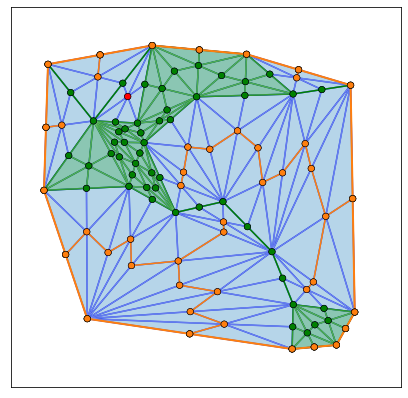

In [37]:
draw_Sup( sM , sL , Lbar, indices, pos = sPointsM, posSub = sPointsL, boundaryComponent = markedEdges, excludedVerts=excludedVerts)

In [38]:
ValidCC

[[36]]

# Now compute the representative of each cycle

In [39]:
pointsM.shape

(20, 2)

In [40]:
offset = pointsM.shape[0]
ReprEdges = []

EL = [ x for x in M if len(x)==2 ]
EL = list(sorted(EL))

for simps in ValidCC:
    
    ReprTriangles = []
   
    for s in simps:

        simplex = M[s - offset]
        if len(simplex) == 3:

            ReprTriangles.append(simplex)

    
    Boundary = np.zeros( ( len(EL), len(ReprTriangles) ), dtype=int)

    for i,T in enumerate(ReprTriangles):

        e0 = EL.index( [T[0], T[1]] )
        e1 = EL.index( [T[0], T[2]] )
        e2 = EL.index( [T[1], T[2]] )
        
        Boundary[ e0 , i ] = 1
        Boundary[ e1 , i ] = 1
        Boundary[ e2 , i ] = 1
    
    outerCycle = np.sum( Boundary, axis = 1 )
    outerCycle = np.mod(outerCycle, 2)
    
    ReprEdges.extend([ e for i,e in enumerate(EL) if outerCycle[i]==1 ] )
        

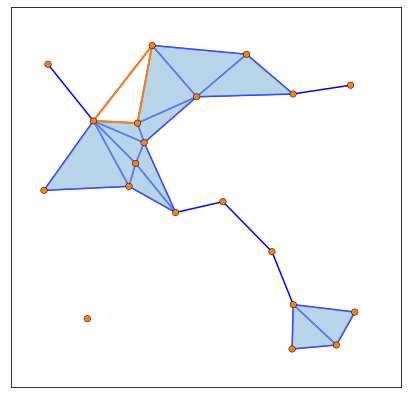

In [41]:
draw_2d_simplicial_complex(L, pointsM, markedEdges=ReprEdges)

## Proof that edges in the representative cycles are in $L$ 

1. All is manifold: so every edge is the boundary of at most 2 triangles
2. Since it's $Z_2$, an edge is in the cycle iff it is the boundary of only one triangle corresponding to a point in $\bar{L}$.
3. This means that the edge is also the boundary of a triangle in $L$, or the edge is in $L$ and not the boundary of any triangle in $L$, such as the outer rim ?